參考文章 : https://github.com/andy6804tw/2021-13th-ironman/tree/main/11.SVM

# SVM 分類器

支持向量機 (support vector machine, SVM) 是一個基於統計學習的監督式演算法，<font color = orange>透過找出一個超平面，使之將兩個不同的集合分開</font>。一般的分類問題我們就是要找出在不同的資料類別中的分隔線。但在一般狀況下這個分隔線非常複雜且有很多種可能。然而 SVM 就是要在這很多種的可能當中找出最佳的解。<font color = orange>SVM 演算法的精神就是找出一條分隔線使所有在邊界上的點離得越遠越好，使模型抵抗雜訊的能力更佳。</font>

<img src="https://raw.githubusercontent.com/andy6804tw/2021-13th-ironman/main/11.SVM/image/img11-1.png" width="50%" height="50%">

In [1]:
#pip install seaborn


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris

# 載入資料

In [3]:
iris = load_iris()
df_data = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= ['SepalLengthCm','SepalWidthCm','PetalLengthCm','PetalWidthCm','Species']) #np.c_ 合併資料，這邊類似R的cbind
df_data

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2.0
146,6.3,2.5,5.0,1.9,2.0
147,6.5,3.0,5.2,2.0,2.0
148,6.2,3.4,5.4,2.3,2.0


# 分割訓練集與測試集

In [4]:
from sklearn.model_selection import train_test_split
X = df_data.drop(labels=['Species'],axis=1).values # 移除Species並取得剩下欄位資料
y = df_data['Species'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) #stratify = y : 根據數據y中各類數據比例，分配給train和test，使得各類數據比例和原數據集一樣。

print('train shape:', X_train.shape)
print('test shape:', X_test.shape)

train shape: (105, 4)
test shape: (45, 4)


# 繪製決策邊界 Function

In [5]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

# PCA降維

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, iterated_power=1) #降成2維，方便作圖
train_reduced = pca.fit_transform(X_train)

### sklearn.decomposition.PCA
- n_components : PCA算法中要保留的主成分個數
  - 可賦值為string,如n_components='mle', 會自動選取特徵個數n, 使得滿足所要求的方差百分比
- copy : bool, True or False, 缺少時默認True
  - 表示是否在運行算法時，將原始訓練數據複製一份。若為 True，運行PCA後, 原始訓練數據的值不會有任何改變, 因為是在原始數據的副本上進行運算的。
- iterated_power : 冪方法的迭代次數, 默認為3
- whiten : bool,省略時為False. 白化,對降維後的數據的每個特徵進行歸一化，讓方差都為1.

### 支持向量機 (Support Vector Machine, SVM) 模型

SVM 能夠透過 C 來達到 weight regularization 來限制模型的複雜度。除了這點我們還能透過 SVM 的 Kernel trick 的方式將資料做非線性轉換，常見的 kernel 除了 linear 線性以外還有兩了非線性的 Polynomial 高次方轉換以及 Radial Basis Function 高斯轉換。

### Kernel
* 當不同類別的資料在原始空間中無法被線性分類器區隔開來時，經由非線性投影後的資料能在更高維度的空間中可以更區隔開。

[圖片來源](https://chih-sheng-huang821.medium.com/%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92-kernel-%E5%87%BD%E6%95%B8-47c94095171)

<img src="https://imgur.com/VrwbMzm.png" width="50%" height="50%">


### 四種不同SVC分類器:

1. LinearSVC (線性)
2. kernel='linear' (線性)
3. kernel='poly' (非線性)
4. kernel='rbf' (非線性)

### Methods:

* fit: 放入X、y進行模型擬合。
* predict: 預測並回傳預測類別。
* score: 預測成功的比例。
* predict_proba: 預測每個類別的機率值。

## LinearSVC
#### Parameters:

- C: 限制模型的複雜度，防止過度擬合。
- max_iter: 最大迭代次數，預設1000。 

In [8]:
from sklearn import svm

# 建立 linearSvc 模型
linearSvcModel=svm.LinearSVC(C=1, max_iter=10000)
# 使用訓練資料訓練模型
linearSvcModel.fit(train_reduced, y_train)
# 使用訓練資料預測分類
predicted=linearSvcModel.predict(train_reduced)
# 計算準確率
accuracy = linearSvcModel.score(train_reduced, y_train)



Text(0.5, 1.0, 'LinearSVC (linear kernel)\nAccuracy:0.96')

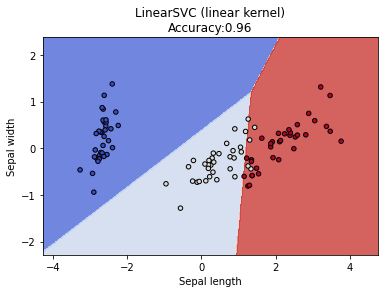

In [9]:
X0, X1 = train_reduced[:, 0], train_reduced[:, 1]  #PC1, PC2
xx, yy = make_meshgrid(X0, X1) #網格
plot_contours(plt, linearSvcModel, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8) #畫背景
plt.scatter(X0, X1, c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors='k')  #s:圓圈大小
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.title('LinearSVC (linear kernel)'+ '\n' + 'Accuracy:%.2f'%accuracy)

In [10]:
print(np.meshgrid(np.arange(1, 2, 0.2),np.arange(1, 2, 0.2)))  #


[array([[1. , 1.2, 1.4, 1.6, 1.8],
       [1. , 1.2, 1.4, 1.6, 1.8],
       [1. , 1.2, 1.4, 1.6, 1.8],
       [1. , 1.2, 1.4, 1.6, 1.8],
       [1. , 1.2, 1.4, 1.6, 1.8]]), array([[1. , 1. , 1. , 1. , 1. ],
       [1.2, 1.2, 1.2, 1.2, 1.2],
       [1.4, 1.4, 1.4, 1.4, 1.4],
       [1.6, 1.6, 1.6, 1.6, 1.6],
       [1.8, 1.8, 1.8, 1.8, 1.8]])]


In [11]:
print(xx.ravel())
print(np.c_[xx.ravel(),yy.ravel()]) #把網格變成[X,Y]

[-4.26845324 -4.24845324 -4.22845324 ...  4.71154676  4.73154676
  4.75154676]
[[-4.26845324 -2.28491222]
 [-4.24845324 -2.28491222]
 [-4.22845324 -2.28491222]
 ...
 [ 4.71154676  2.37508778]
 [ 4.73154676  2.37508778]
 [ 4.75154676  2.37508778]]


In [12]:
test = linearSvcModel.predict(np.c_[xx.ravel(),yy.ravel()])
print(test)
print('-'*50)
print(test.reshape(xx.shape)) #放入對應的位置

[1. 1. 1. ... 2. 2. 2.]
--------------------------------------------------
[[1. 1. 1. ... 2. 2. 2.]
 [1. 1. 1. ... 2. 2. 2.]
 [1. 1. 1. ... 2. 2. 2.]
 ...
 [0. 0. 0. ... 2. 2. 2.]
 [0. 0. 0. ... 2. 2. 2.]
 [0. 0. 0. ... 2. 2. 2.]]


## kernel='linear'
#### Parameters:

* C: 限制模型的複雜度，防止過度擬合。
* kernel: 此範例採用線性。

Text(0.5, 1.0, 'SVC with linear kernel\nAccuracy:0.97')

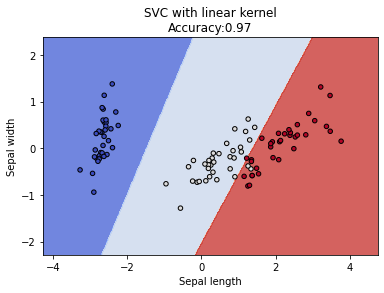

In [13]:
from sklearn import svm

# 建立 kernel='linear' 模型
svcModel=svm.SVC(kernel='linear', C=1)
# 使用訓練資料訓練模型
svcModel.fit(train_reduced, y_train)
# 使用訓練資料預測分類
predicted=svcModel.predict(train_reduced)
# 計算準確率
accuracy = svcModel.score(train_reduced, y_train)

X0, X1 = train_reduced[:, 0], train_reduced[:, 1]
xx, yy = make_meshgrid(X0, X1)
plot_contours(plt, svcModel, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X0, X1, c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.title('SVC with linear kernel'+ '\n' + 'Accuracy:%.2f'%accuracy)

## kernel='poly'
#### Parameters:

- C: 限制模型的複雜度，防止過度擬合。
- kernel: 此範例採用 Polynomial 高次方轉換。
- degree: 增加模型複雜度，3 代表轉換到三次空間進行分類。
- gamma: 數值越大越能做複雜的分類邊界。

Text(0.5, 1.0, 'SVC with polynomial (degree 3) kernel\nAccuracy:0.97')

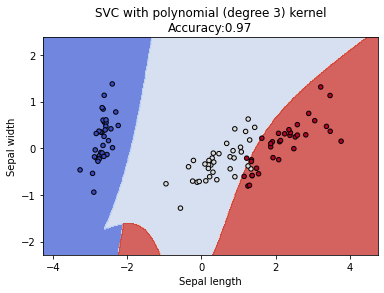

In [14]:
from sklearn import svm

# 建立 kernel='poly' 模型
polyModel=svm.SVC(kernel='poly', degree=3, gamma='auto', C=1)
# 使用訓練資料訓練模型
polyModel.fit(train_reduced, y_train)
# 使用訓練資料預測分類
predicted=polyModel.predict(train_reduced)
# 計算準確率
accuracy = polyModel.score(train_reduced, y_train)

X0, X1 = train_reduced[:, 0], train_reduced[:, 1]
xx, yy = make_meshgrid(X0, X1)
plot_contours(plt, polyModel, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X0, X1, c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.title('SVC with polynomial (degree 3) kernel'+ '\n' + 'Accuracy:%.2f'%accuracy)

## kernel='rbf'
#### Parameters:

* C: 限制模型的複雜度，防止過度擬合。
* kernel: 此範例採用 Radial Basis Function 高斯轉換。
* gamma: 數值越大越能做複雜的分類邊界

Text(0.5, 1.0, 'SVC with RBF kernel\nAccuracy:0.97')

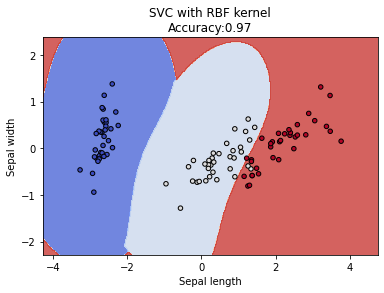

In [15]:
from sklearn import svm

# 建立 kernel='rbf' 模型
rbfModel=svm.SVC(kernel='rbf', gamma=0.7, C=1)
# 使用訓練資料訓練模型
rbfModel.fit(train_reduced, y_train)
# 使用訓練資料預測分類
predicted=rbfModel.predict(train_reduced)
# 計算準確率
accuracy = rbfModel.score(train_reduced, y_train)

X0, X1 = train_reduced[:, 0], train_reduced[:, 1]
xx, yy = make_meshgrid(X0, X1)
plot_contours(plt, rbfModel, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X0, X1, c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.title('SVC with RBF kernel'+ '\n' + 'Accuracy:%.2f'%accuracy)

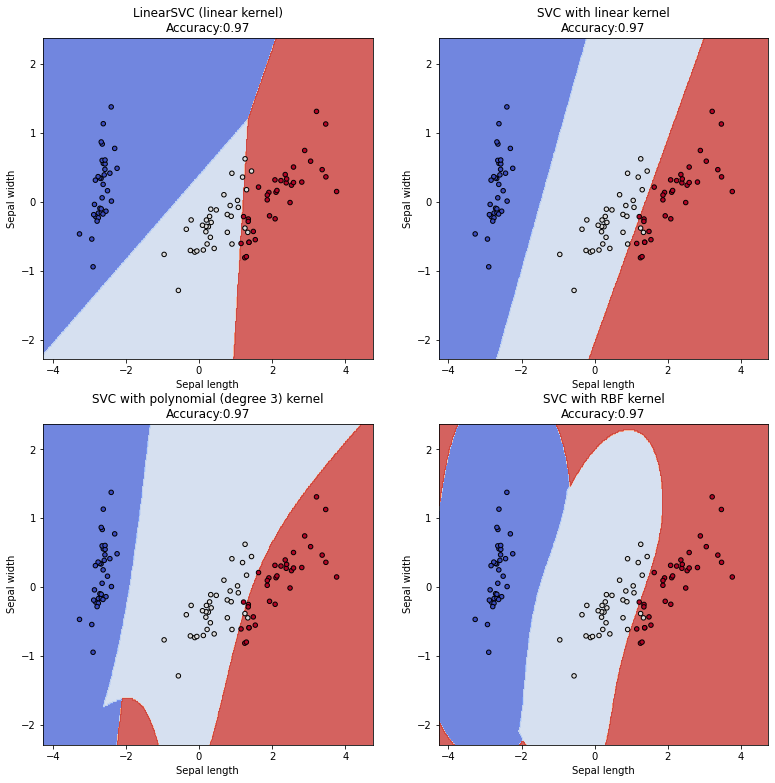

In [24]:
plt.figure(figsize=(13,13)) #創建畫布

####
plt.subplot(2,2,1)
plot_contours(plt, linearSvcModel, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8) #畫背景
plt.scatter(X0, X1, c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors='k')  #s:圓圈大小
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.title('LinearSVC (linear kernel)'+ '\n' + 'Accuracy:%.2f'%accuracy)


####
plt.subplot(2,2,2)
X0, X1 = train_reduced[:, 0], train_reduced[:, 1]
xx, yy = make_meshgrid(X0, X1)
plot_contours(plt, svcModel, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X0, X1, c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.title('SVC with linear kernel'+ '\n' + 'Accuracy:%.2f'%accuracy)



####
plt.subplot(2,2,3)
X0, X1 = train_reduced[:, 0], train_reduced[:, 1]
xx, yy = make_meshgrid(X0, X1)
plot_contours(plt, polyModel, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X0, X1, c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.title('SVC with polynomial (degree 3) kernel'+ '\n' + 'Accuracy:%.2f'%accuracy)


####
plt.subplot(2,2,4)
X0, X1 = train_reduced[:, 0], train_reduced[:, 1]
xx, yy = make_meshgrid(X0, X1)
plot_contours(plt, rbfModel, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X0, X1, c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.title('SVC with RBF kernel'+ '\n' + 'Accuracy:%.2f'%accuracy)
plt.show()